# Does your dorm matter for your well-being?

We build models to predict:
1. Spring well-being from fall well-being
1. Spring well-being from fall well-being and demographic items (age, family income, family education, race, gender)
1. Spring well-being from fall well-being and demographic items and fixed effects per dorm

We are interested in the gain in variance explained from step 2 to step 3. Because we get additional degrees of freedom by including more columns, we expect this fit to increase even if the dorm is meaningless. To combat this, we use random shuffling to determine how likely this much additional fit would occur if dorms were truly irrelevant (by randomly shuffling dorm assignments 1000 times and computing the explained-variance-gain under each).

# Results:
- 41% of spring well-being can be explained by fall well-being along
- Another 8% can be explained by adding demographic variables. 20% can be explained by demographic variables alone (that is, without fall well-being).
- Another 5% can be explained by what dorm the student was in. If fall well-being is not included in the model, the gain increases to 9% (from 20% to 29%).
  - p-values for these two results are 0.05 and 0.02 respectively, so results are slightly significant.
- Note that the above does not hold if we try to predict *fall* well-being from dorm (p = 0.55), implying that dorm has no effect on their fall well-being score (taken in week 2, so this is consistent with the interpretation that dorm only impacts well-being over time).

# Conclusion:
- Dorm may matter a little bit.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configure" data-toc-modified-id="Configure-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configure</a></span></li><li><span><a href="#Import-and-load" data-toc-modified-id="Import-and-load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import and load</a></span></li><li><span><a href="#Quick-summary-of-whole-dorm-well-beings" data-toc-modified-id="Quick-summary-of-whole-dorm-well-beings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quick summary of whole-dorm well-beings</a></span></li><li><span><a href="#Base-model,-minimal-predictors" data-toc-modified-id="Base-model,-minimal-predictors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Base model, minimal predictors</a></span></li><li><span><a href="#Model-with-demographic-covariates" data-toc-modified-id="Model-with-demographic-covariates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model with demographic covariates</a></span></li></ul></div>

## Configure

In [7]:
lines = '''RACE_LOOKUP["South Asian"] = "south_asian"
RACE_LOOKUP["Hispanic or Latino/a"] = "hispanic"
RACE_LOOKUP["Black or African American"] = "black"
RACE_LOOKUP["East Asian"] = "east_asian"
RACE_LOOKUP["White or Caucasian"] = "white"'''
for line in lines.splitlines():
    from_race = line.split('"')[1]
    to_race = line.split('"')[-2]
    print(f"'{from_race}' = '{to_race}',")

'South Asian' = 'south_asian',
'Hispanic or Latino/a' = 'hispanic',
'Black or African American' = 'black',
'East Asian' = 'east_asian',
'White or Caucasian' = 'white',


In [1]:
INPUT_DATAFILE = '../data/2018-2019/postprocessed/final_for_analysis.csv'
INCLUDE_FALL_WB_AS_PREDICTOR = True
INCLUDE_DEMOS_AS_PREDICTOR = True
# DV = 'Wellbeing_fall'
DV = 'Wellbeing_spring'

if INCLUDE_FALL_WB_AS_PREDICTOR:
    assert DV != 'Wellbeing_fall'

## Import and load

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

Everett Wetchler 2020-01-20 08:36:04 PST 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
matplotlib 3.1.0
seaborn 0.9.0
watermark 2.0.1


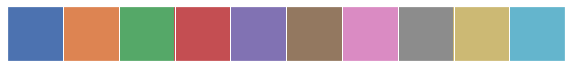

In [3]:
import datetime as dt
import os
import random
import re
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [4]:
from sklearn import linear_model, dummy

In [5]:
df = pd.read_csv(INPUT_DATAFILE, index_col='PID')
print(df.shape)
df.head()

(204, 61)


,NID,Age,FinclAid,FatherEd,MotherEd,FmlyIncome,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,Need_Belong,Prosociality,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress,Wellbeing_fall,Wellbeing_spring,Gender_M,Gender_other,Race_Black or African American,Race_Pacific Islander,Race_Other,Race_American Indian,Race_Hispanic or Latino/a,Race_South Asian,Race_Middle Eastern,Race_East Asian,Race_White or Caucasian
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
vgxlTMkQs5,7.0,18.0,0.0,4.0,4.0,87500.000000,4.0,4.0,5.5,3.5,3.333333,4.142857,6.75,5.25,4.25,2.75,3.8,2.666667,3.000000,4.750,4.000,3.1,19.0,2.785714,2.50,3.5,2.5,2.00,2.75,2.50,4.75,4.00,4.000000,3.25,1.375,3.857143,2.25,2.0,3.2,6.00,3.166667,4.833333,1.0,2.000000,4.50,2.166667,1.857143,1.428571,-2.063548,-0.765354,1,0,0,0,0,0,0,0,0,0,1
M9obKkDvc0,11.0,18.0,1.0,3.5,3.5,115856.741573,6.0,4.5,5.0,4.5,5.000000,4.000000,6.50,6.25,7.00,6.50,3.8,4.000000,3.000000,5.625,5.625,2.2,14.0,3.571429,2.50,2.5,2.5,2.50,2.50,2.50,4.00,4.00,4.000000,4.00,4.000,5.000000,4.00,4.0,4.0,7.00,7.000000,5.000000,5.0,5.000000,5.00,2.833333,2.571429,2.000000,-0.011434,-0.049972,0,0,0,0,0,0,0,1,0,0,0
RdS4vMvQjo,9.0,18.0,1.0,4.0,4.0,125000.000000,3.0,6.0,6.5,5.0,2.533333,3.142857,4.75,5.75,4.50,4.00,3.6,2.750000,3.166667,3.375,4.000,1.8,10.0,2.571429,4.00,3.0,3.5,2.75,2.25,4.00,3.75,3.25,3.833333,2.75,2.500,1.857143,2.00,3.0,2.8,2.25,4.666667,2.166667,1.0,2.666667,1.00,2.500000,2.142857,1.285714,0.919656,0.665411,1,0,0,0,0,0,0,0,0,0,1
n08loMfJH7,4.0,18.0,0.0,4.0,2.5,200000.000000,4.0,5.5,6.5,5.5,3.000000,3.714286,5.25,5.75,4.50,4.25,3.6,3.000000,3.333333,4.750,3.875,2.0,13.0,2.285714,2.75,3.0,3.0,3.00,2.75,3.25,4.25,3.50,4.166667,3.50,3.000,2.857143,3.25,3.0,3.4,3.25,4.833333,3.000000,1.0,2.500000,1.25,2.833333,2.142857,0.857143,0.653420,0.486565,0,0,0,0,0,0,0,0,0,1,0
8rsekwqjFy,5.0,18.0,1.0,2.5,2.5,125000.000000,4.5,5.0,6.0,5.0,2.800000,4.000000,6.75,6.25,4.75,4.00,3.7,2.666667,3.666667,3.500,4.875,1.8,18.0,2.571429,3.50,3.0,3.5,3.00,3.00,3.00,4.00,3.50,4.333333,2.50,3.000,2.000000,3.00,3.5,3.8,4.25,5.166667,4.333333,1.0,4.000000,1.25,2.666667,2.142857,2.000000,0.698392,-0.049972,1,0,0,0,0,0,0,1,0,0,0


## Quick summary of whole-dorm well-beings

In [6]:
df.groupby('NID').mean()[['Wellbeing_fall', 'Wellbeing_spring']]

,Wellbeing_fall,Wellbeing_spring
NID,,
1.0,0.179581,0.430676
2.0,0.100396,0.230491
4.0,-0.042138,0.008712
5.0,0.053229,0.018411
7.0,0.069026,0.171642
8.0,-0.150949,-0.458762
9.0,-0.097492,-0.348048
10.0,-0.351179,-0.301473
11.0,0.147341,0.152720


## Base model, minimal predictors

In [7]:
def fit_and_score(frame, ivs):
    X = frame[ivs].values
    y = frame[DV].values
    if ivs:
        model = linear_model.LinearRegression()
    else:
        model = dummy.DummyRegressor()
    model.fit(X, y)
    r2 = model.score(X, y)
    return model, r2

In [8]:
if INCLUDE_FALL_WB_AS_PREDICTOR:
    base_model, base_model_r2 = fit_and_score(df, ['Wellbeing_fall'])
    print("Score:", base_model_r2)
    print("Coefficients:", base_model.coef_)
else:
    base_model_r2 = 0
    print("Intercept-only model has an r² of 0 by definition")

Score: 0.4138844395694118
Coefficients: [0.64333851]


## Model with demographic covariates

In [9]:
df.columns

Index(['NID', 'Age', 'FinclAid', 'FatherEd', 'MotherEd', 'FmlyIncome',
       'Extraversion', 'Agreeableness', 'Openness', 'Conscientiousness', 'NPI',
       'Positive_empathy', 'Pos_efficacy', 'Neg_efficacy', 'Pos_tendency',
       'Neg_Tendency', 'Need_Belong', 'Prosociality', 'Emp_theory', 'RS_1',
       'RS_2', 'Self_Esteem', 'Self_monitor', 'Distress_Disclosure',
       'Guidance', 'Warmth', 'Integration', 'Attachment', 'Nurturance',
       'Reliable', 'Anticipated_Risks', 'Anticipated_Benefits', 'PI', 'SI',
       'CI', 'BFNE', 'BAS_drive', 'BAS_Fun_seeking',
       'BAS_Fun_Reward_responsiveness', 'Suppression', 'Cogntive_Reappraisal',
       'Extensic_improve', 'Extensic_worse', 'Intrinsic_imrpove',
       'Intrinsic_worse', 'Empathic_Concern', 'Perspective_Taking',
       'Personal_Distress', 'Wellbeing_fall', 'Wellbeing_spring', 'Gender_M',
       'Gender_other', 'Race_Black or African American',
       'Race_Pacific Islander', 'Race_Other', 'Race_American Indian',
       'Ra

In [3]:
for d in [
        'Age',
        'FatherEd', 'MotherEd', 
        'FinclAid', 'FmlyIncome',
        'Gender_M', 'Gender_other',
        'Race_Black or African American',
        'Race_Pacific Islander', 'Race_Other', 'Race_American Indian',
        'Race_Hispanic or Latino/a', 'Race_South Asian', 'Race_Middle Eastern',
        'Race_East Asian', 'Race_White or Caucasian']:
    d = d.replace(' ', '.').replace('/', '.')
    print(d, '+', end=' ')

Age + FatherEd + MotherEd + FinclAid + FmlyIncome + Gender_M + Gender_other + Race_Black.or.African.American + Race_Pacific.Islander + Race_Other + Race_American.Indian + Race_Hispanic.or.Latino.a + Race_South.Asian + Race_Middle.Eastern + Race_East.Asian + Race_White.or.Caucasian + 

In [10]:
ivs = ['Wellbeing_fall'] if INCLUDE_FALL_WB_AS_PREDICTOR else []

if INCLUDE_DEMOS_AS_PREDICTOR:
    demographic_cols = [
        'Age',
        'FatherEd', 'MotherEd', 
        'FinclAid', 'FmlyIncome',
        'Gender_M', 'Gender_other',
        'Race_Black or African American',
        'Race_Pacific Islander', 'Race_Other', 'Race_American Indian',
        'Race_Hispanic or Latino/a', 'Race_South Asian', 'Race_Middle Eastern',
        'Race_East Asian', 'Race_White or Caucasian']
    ivs.extend(demographic_cols)

    demo_model, demo_model_r2 = fit_and_score(df, ivs)
    print("Score (predicting %s):" % DV, demo_model_r2)
    print("Coefficients:")
    for k, v in list(zip(ivs, demo_model.coef_)):
        print(f'{v:.6f}  {k}')

Score (predicting Wellbeing_spring): 0.49257485000817314
Coefficients:
0.586359  Wellbeing_fall
-0.008935  Age
0.159905  FatherEd
-0.209553  MotherEd
-0.024372  FinclAid
0.000001  FmlyIncome
0.204600  Gender_M
0.190056  Gender_other
-0.122846  Race_Black or African American
-0.158654  Race_Pacific Islander
-0.307953  Race_Other
-1.395790  Race_American Indian
-0.002903  Race_Hispanic or Latino/a
-0.089695  Race_South Asian
-0.193136  Race_Middle Eastern
0.050336  Race_East Asian
0.144721  Race_White or Caucasian


In [11]:
frame = pd.get_dummies(df, columns=['NID'], drop_first=True)
frame.head()

,Age,FinclAid,FatherEd,MotherEd,FmlyIncome,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,Need_Belong,Prosociality,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress,Wellbeing_fall,Wellbeing_spring,Gender_M,Gender_other,Race_Black or African American,Race_Pacific Islander,Race_Other,Race_American Indian,Race_Hispanic or Latino/a,Race_South Asian,Race_Middle Eastern,Race_East Asian,Race_White or Caucasian,NID_2.0,NID_4.0,NID_5.0,NID_7.0,NID_8.0,NID_9.0,NID_10.0,NID_11.0,NID_13.0,NID_15.0
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
vgxlTMkQs5,18.0,0.0,4.0,4.0,87500.000000,4.0,4.0,5.5,3.5,3.333333,4.142857,6.75,5.25,4.25,2.75,3.8,2.666667,3.000000,4.750,4.000,3.1,19.0,2.785714,2.50,3.5,2.5,2.00,2.75,2.50,4.75,4.00,4.000000,3.25,1.375,3.857143,2.25,2.0,3.2,6.00,3.166667,4.833333,1.0,2.000000,4.50,2.166667,1.857143,1.428571,-2.063548,-0.765354,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
M9obKkDvc0,18.0,1.0,3.5,3.5,115856.741573,6.0,4.5,5.0,4.5,5.000000,4.000000,6.50,6.25,7.00,6.50,3.8,4.000000,3.000000,5.625,5.625,2.2,14.0,3.571429,2.50,2.5,2.5,2.50,2.50,2.50,4.00,4.00,4.000000,4.00,4.000,5.000000,4.00,4.0,4.0,7.00,7.000000,5.000000,5.0,5.000000,5.00,2.833333,2.571429,2.000000,-0.011434,-0.049972,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
RdS4vMvQjo,18.0,1.0,4.0,4.0,125000.000000,3.0,6.0,6.5,5.0,2.533333,3.142857,4.75,5.75,4.50,4.00,3.6,2.750000,3.166667,3.375,4.000,1.8,10.0,2.571429,4.00,3.0,3.5,2.75,2.25,4.00,3.75,3.25,3.833333,2.75,2.500,1.857143,2.00,3.0,2.8,2.25,4.666667,2.166667,1.0,2.666667,1.00,2.500000,2.142857,1.285714,0.919656,0.665411,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
n08loMfJH7,18.0,0.0,4.0,2.5,200000.000000,4.0,5.5,6.5,5.5,3.000000,3.714286,5.25,5.75,4.50,4.25,3.6,3.000000,3.333333,4.750,3.875,2.0,13.0,2.285714,2.75,3.0,3.0,3.00,2.75,3.25,4.25,3.50,4.166667,3.50,3.000,2.857143,3.25,3.0,3.4,3.25,4.833333,3.000000,1.0,2.500000,1.25,2.833333,2.142857,0.857143,0.653420,0.486565,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
8rsekwqjFy,18.0,1.0,2.5,2.5,125000.000000,4.5,5.0,6.0,5.0,2.800000,4.000000,6.75,6.25,4.75,4.00,3.7,2.666667,3.666667,3.500,4.875,1.8,18.0,2.571429,3.50,3.0,3.5,3.00,3.00,3.00,4.00,3.50,4.333333,2.50,3.000,2.000000,3.00,3.5,3.8,4.25,5.166667,4.333333,1.0,4.000000,1.25,2.666667,2.142857,2.000000,0.698392,-0.049972,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
for c in frame.columns:
    if c.startswith('NID'):
        ivs.append(c)

In [13]:
dorm_model, dorm_model_r2 = fit_and_score(frame, ivs)
print("Score (predicting %s):" % DV, dorm_model_r2)
print("Coefficients:")
for k, v in list(zip(ivs, dorm_model.coef_)):
    print(f'{v:.6f}  {k}')

Score (predicting Wellbeing_spring): 0.541156117990349
Coefficients:
0.553777  Wellbeing_fall
0.113960  Age
0.158805  FatherEd
-0.212402  MotherEd
-0.003136  FinclAid
0.000001  FmlyIncome
0.197924  Gender_M
0.269189  Gender_other
-0.144240  Race_Black or African American
-0.195534  Race_Pacific Islander
-0.521327  Race_Other
-1.366046  Race_American Indian
0.050448  Race_Hispanic or Latino/a
0.014459  Race_South Asian
-0.284498  Race_Middle Eastern
0.169894  Race_East Asian
0.117914  Race_White or Caucasian
-0.045174  NID_2.0
-0.177650  NID_4.0
-0.228450  NID_5.0
-0.029563  NID_7.0
-0.725480  NID_8.0
-0.234500  NID_9.0
-0.203618  NID_10.0
-0.295168  NID_11.0
-0.781409  NID_13.0
-0.014282  NID_15.0


In [14]:
scores = []
for i in range(1000):
    shuffled = df.copy()
    shuffled['NID'] = shuffled['NID'].sample(frac=1.0).values
    shuffled = pd.get_dummies(shuffled, columns=['NID'], drop_first=True)
    tmp_model, tmp_model_r2 = fit_and_score(shuffled, ivs)
    scores.append(tmp_model_r2)

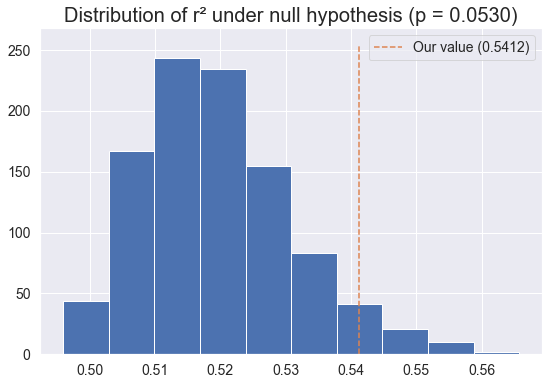

In [15]:
fig, ax = plt.subplots(1)
pd.Series(scores).hist(ax=ax)
ax.plot([dorm_model_r2, dorm_model_r2], ax.get_ylim(), linestyle='--', label='Our value (%.4f)' % dorm_model_r2)
p = np.mean([0 if s < dorm_model_r2 else 1 for s in scores ])
ax.set_title("Distribution of r² under null hypothesis (p = %.4f)" % p)
ax.legend()